# Build a DNN using the Keras Functional API




## Learning objectives

1. Review how to read in CSV file data using tf.data.
2. Specify input, hidden, and output layers in the DNN architecture.
3. Review and visualize the final DNN shape.
4. Train the model locally and visualize the loss curves.
5. Deploy and predict with the model using Cloud AI Platform. 


## Introduction

In this notebook, we will build a Keras DNN to predict the fare amount for NYC taxi cab rides.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/neural_network.ipynb).

In [20]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [3]:
import os, json, math
import numpy as np
import shutil
import tensorflow as tf

from tensorflow.keras.layers import Normalization, Dense, Layer
from tensorflow.keras.activations import relu, sigmoid, linear
from tensorflow.keras.models import Model
from tensorflow.data import Dataset
from tensorflow.keras import KerasTensor
from tensorflow.keras.layers import concatenate

print("TensorFlow version: ",tf.version.VERSION)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # SET TF ERROR LOG VERBOSITY

TensorFlow version:  2.16.1


## Locating the CSV files

We will start with the CSV files that we wrote out in the other notebook. Just so you don't have to run the notebook, we saved a copy in ../data/toy_data

In [4]:
!ls -l ../test_data/taxi_traffic/toy_data/*.csv

-rw-r--r--@ 1 klawrence@simplemachines.com.au  staff  1111933 11 Apr 10:03 ../test_data/taxi_traffic/toy_data/taxi-traffic-test_toy.csv
-rw-r--r--@ 1 klawrence@simplemachines.com.au  staff  4772181 11 Apr 10:03 ../test_data/taxi_traffic/toy_data/taxi-traffic-train_toy.csv
-rw-r--r--@ 1 klawrence@simplemachines.com.au  staff  1038564 11 Apr 10:03 ../test_data/taxi_traffic/toy_data/taxi-traffic-valid_toy.csv


## Lab Task 1: Use tf.data to read the CSV files


First let's define our columns of data, which column we're predicting for, and the default values.

In [5]:
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

Next, let's define our features we want to use and our label(s) and then load in the dataset for training.

In [6]:
def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

def load_dataset(pattern: str, batch_size: int = 1, mode: str = 'eval') -> Dataset:
    _kwargs = {
        'batch_size': batch_size,
        'column_names': CSV_COLUMNS,
        'column_defaults': DEFAULTS,
        'header': False,
        'num_epochs': 1
    }
    if mode == 'train':
        _kwargs['shuffle'] = True
        _kwargs['num_epochs'] = 10

    dataset = tf.data.experimental.make_csv_dataset(pattern, **_kwargs).map(features_and_labels)
    dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE

    if True:
        test = dataset.map(lambda x,y: x)
        for _d in list(test.as_numpy_iterator()):
            for keys, vals in _d.items():
                # print(f'key: {keys}, and value is {vals}')
                if vals.shape != (batch_size,):
                    print(f'key: {keys}, and shape is {vals.shape}')

    return dataset

## Lab Task 2: Build a DNN with Keras

Now let's build the Deep Neural Network (DNN) model in Keras and specify the input and hidden layers. We will print out the DNN architecture and then visualize it later on.

In [7]:
train_ds: Dataset = load_dataset(
        pattern='../test_data/taxi_traffic/toy_data/taxi-traffic-train_toy*',
        batch_size=100,
        mode='train'
    )
for _ds in train_ds.take(2):
    print(_ds)

(OrderedDict([('pickup_longitude', <tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
      dtype=float32)>), ('pickup_latitude', <tf.Tensor: shape=(100,), dtype=float32, numpy=
array([-74.002205, -73.987595, -73.91988 , -73.96986 , -73.98437 ,
       -74.01012 , -73.949425, -73.93134 , -73.998726, -73.95751 ,
       -73.9937  , -73.98374 , -73.9489  , -73.98106 , -73.984795,
       -73.87286 , -74.00349 , -73.95799 , -74.00526 , -73.977875,
       -73.99986 , -73.99157 , -73.94825 , -74.00404 , -73.984726,
       -73.94941 , -73.987045, -73.992035, -73.

In [8]:
def get_normalization_layer(col_name: str, dataset: Dataset) -> Layer:
    normalizing_l: Layer = Normalization(axis=None)
    normalizing_l.adapt(
        dataset.map(lambda features, labels: features[col_name])
    )
    assert type(normalizing_l) == Normalization, "Normalized Layer normalizing_l is not of type Layer"
    return normalizing_l

In [13]:
## Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    
    debug = True
    INPUT_COLS = ['pickup_longitude', 'pickup_latitude',
                  'dropoff_longitude', 'dropoff_latitude',
                  'passenger_count']

    train_ds = load_dataset(
        pattern='../test_data/taxi_traffic/toy_data/taxi-traffic-train_toy*',
        batch_size=200,
        mode='train'
    )

    normalized_features = [] # Tensors of Normalized Features
    all_inputs = [] # All Input Tensors

    # Numeric features.
    for feature_column in INPUT_COLS:

        if debug:
            print(f'Pre-processing feature column: {feature_column}')

        normalization_layer = get_normalization_layer(feature_column, train_ds)

        if debug:
            print(f'Config of Normalized layer is: {normalization_layer.get_config()}')

        input = tf.keras.Input(shape=(1,), name=feature_column)
        norm_numeric_col = normalization_layer(input)

        assert tf.keras.backend.is_keras_tensor(norm_numeric_col), \
            "norm_numeric_col is not a KerasTensor (aka symbolic tensor)"
        assert tf.keras.backend.is_keras_tensor(input), \
            "input is not a KerasTensor (aka symbolic tensor)"

        normalized_features.append(norm_numeric_col)
        all_inputs.append(input)

    all_features = concatenate(normalized_features)
    
    assert tf.keras.backend.is_keras_tensor(all_features)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1: KerasTensor = Dense(units=32, activation=relu, name='h1')(all_features)
    h2: KerasTensor = Dense(units=8, activation=relu, name='h2')(h1)

    # final output is a linear activation because this is regression
    output: KerasTensor = Dense(units=1, activation=linear, name='output_taxi_fare')(h2)

    assert tf.keras.backend.is_keras_tensor(output), "Output is not a KerasTensor"
    assert tf.keras.backend.is_keras_tensor(h1), "h1 is not a KerasTensor"
    assert tf.keras.backend.is_keras_tensor(h2), "h2 is not a KerasTensor"

    model = Model(all_inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])

    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Pre-processing feature column: pickup_longitude
Config of Normalized layer is: {'name': 'normalization_10', 'trainable': True, 'dtype': 'float32', 'axis': (), 'invert': False, 'mean': None, 'variance': None}
Pre-processing feature column: pickup_latitude
Config of Normalized layer is: {'name': 'normalization_11', 'trainable': True, 'dtype': 'float32', 'axis': (), 'invert': False, 'mean': None, 'variance': None}
Pre-processing feature column: dropoff_longitude
Config of Normalized layer is: {'name': 'normalization_12', 'trainable': True, 'dtype': 'float32', 'axis': (), 'invert': False, 'mean': None, 'variance': None}
Pre-processing feature column: dropoff_latitude
Config of Normalized layer is: {'name': 'normalization_13', 'trainable': True, 'dtype': 'float32', 'axis': (), 'invert': False, 'mean': None, 'variance': None}
Pre-processing feature column: passenger_count
Config of Normalized layer is: {'name': 'normalization_14', 'trainable': True, 'dty

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pickup_longitude    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pickup_latitude     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropoff_longitude   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropoff_latitude    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ passenger_count     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_10    │ (None, 1)         │          3 │ pickup_longitude… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_11    │ (None, 1)         │          3 │ pickup_latitude[… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_12    │ (None, 1)         │          3 │ dropoff_longitud… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_13    │ (None, 1)         │          3 │ dropoff_latitude… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_14    │ (None, 1)         │          3 │ passenger_count[… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 5)         │          0 │ normalization_10… │
│ (Concatenate)       │                   │            │ normalization_11… │
│                     │                   │            │ normalization_12… │
│                     │                   │            │ normalization_13… │
│                     │                   │            │ normalization_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h1 (Dense)          │ (None, 32)        │        192 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h2 (Dense)          │ (None, 8)         │        264 │ h1[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_taxi_fare    │ (None, 1)         │          9 │ h2[0][0]          │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 480 (1.89 KB)

 Trainable params: 465 (1.82 KB)

 Non-trainable params: 15 (80.00 B)

None


In [14]:
print(model.summary(line_length=100))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pickup_longitude            │ (None, 1)               │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ pickup_latitude             │ (None, 1)               │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dropoff_longitude           │ (None, 1)               │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dropoff_latitude            │ (None, 1)               │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ passenger_count             │ (None, 1)               │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ normalization_10            │ (None, 1)               │              3 │ pickup_longitude[0][0]  │
│ (Normalization)             │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ normalization_11            │ (None, 1)               │              3 │ pickup_latitude[0][0]   │
│ (Normalization)             │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ normalization_12            │ (None, 1)               │              3 │ dropoff_longitude[0][0] │
│ (Normalization)             │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ normalization_13            │ (None, 1)               │              3 │ dropoff_latitude[0][0]  │
│ (Normalization)             │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ normalization_14            │ (None, 1)               │              3 │ passenger_count[0][0]   │
│ (Normalization)             │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ concatenate_4 (Concatenate) │ (None, 5)               │              0 │ normalization_10[0][0], │
│                             │                         │                │ normalization_11[0][0], │
│                             │                         │                │ normalization_12[0][0], │
│                             │                         │                │ normalization_13[0][0], │
│                             │                         │                │ normalization_14[0][0]  │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ h1 (Dense)                  │ (None, 32)              │    

 Total params: 480 (1.89 KB)

 Trainable params: 465 (1.82 KB)

 Non-trainable params: 15 (80.00 B)

None


## Lab Task 3: Visualize the DNN

We can visualize the DNN using the Keras [plot_model](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/utils/plot_model) utility.

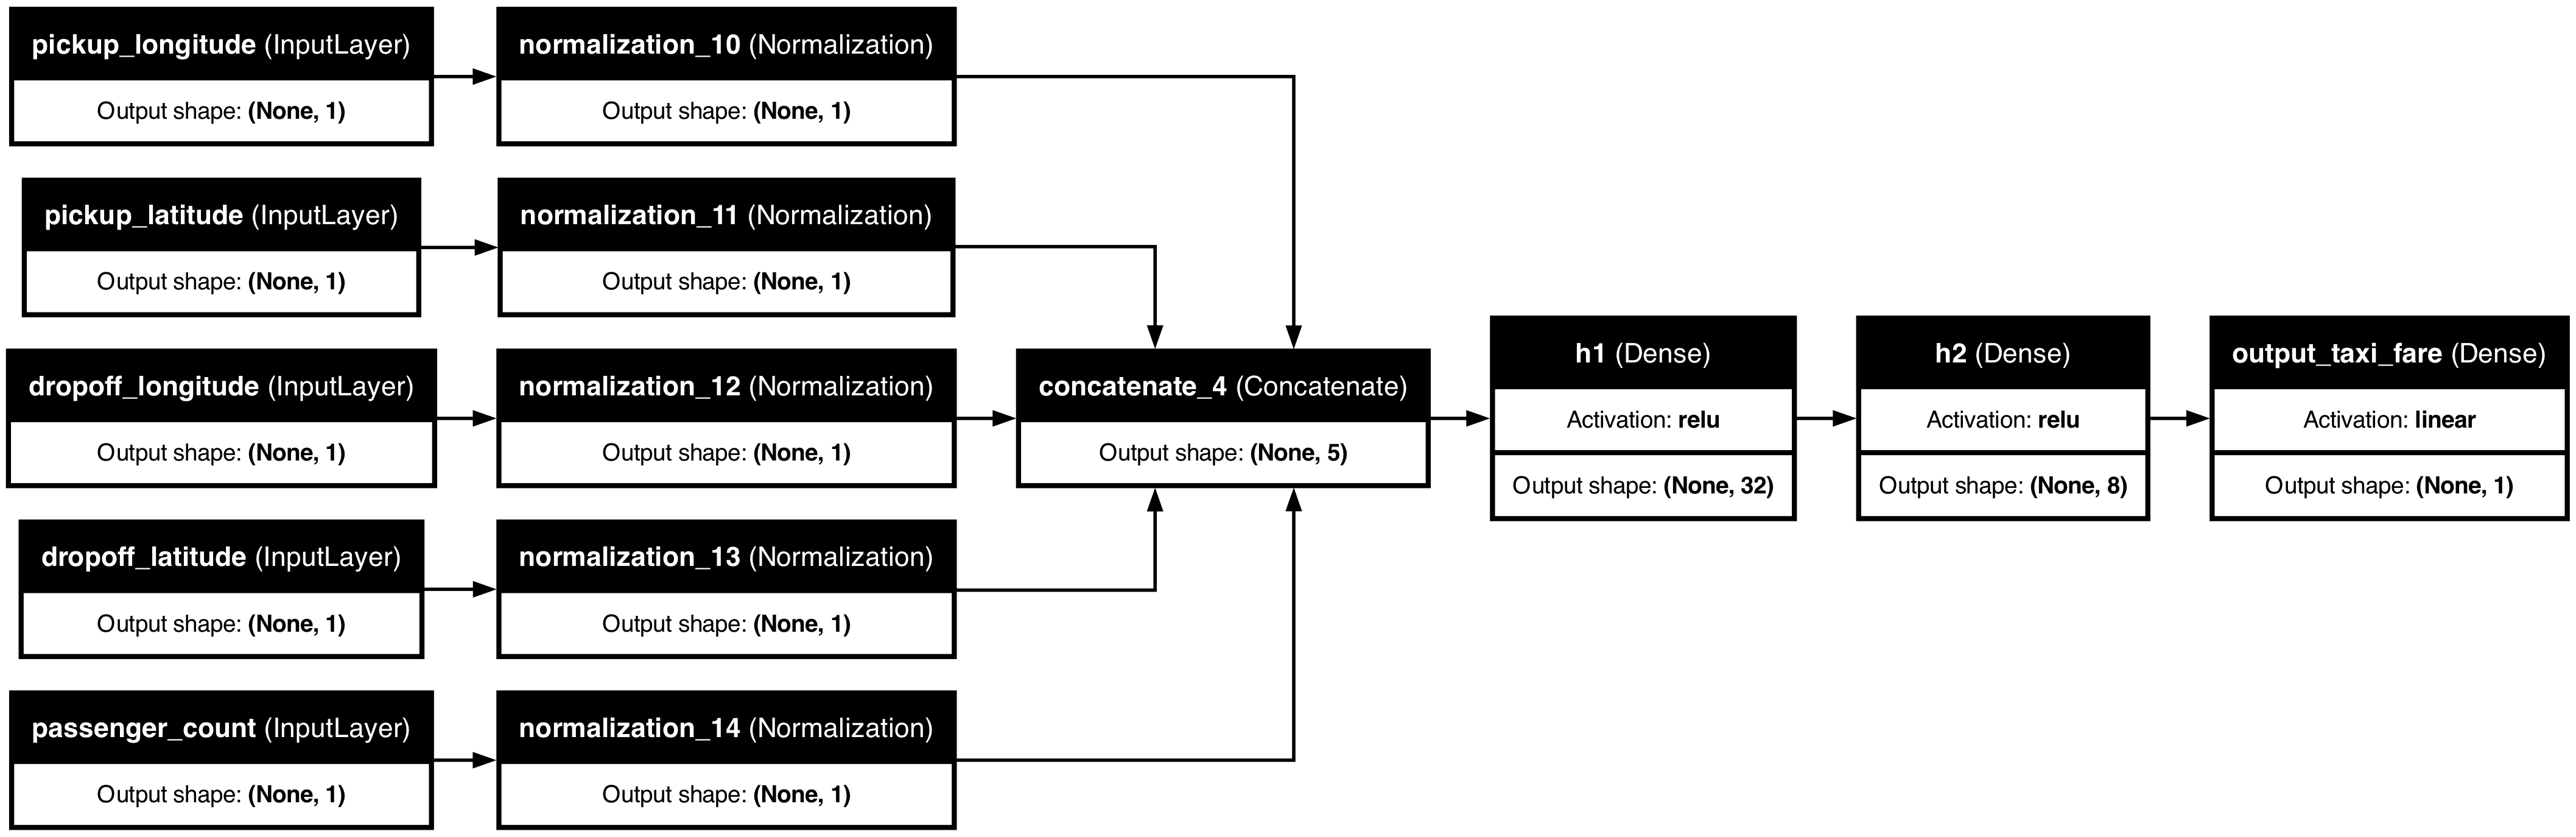

In [22]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=True, rankdir='LR', show_layer_names=True, show_layer_activations=True)

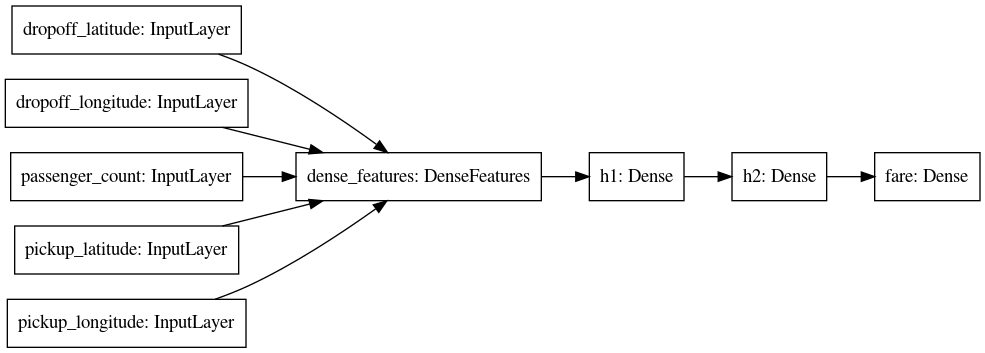

In [26]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Lab Task 4: Train the model

To train the model, simply call [model.fit()](https://keras.io/models/model/#fit).

Note that we should really use many more NUM_TRAIN_EXAMPLES (i.e. a larger dataset). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

In [39]:
steps_per_epoch

48

In [16]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 32  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../test_data/taxi_traffic/toy_data/taxi-traffic-train*', TRAIN_BATCH_SIZE, 'train')
evalds = load_dataset('../test_data/taxi_traffic/toy_data/taxi-traffic-valid*', 1000, 'eval').take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

key: pickup_longitude, and shape is (16,)
key: pickup_latitude, and shape is (16,)
key: dropoff_longitude, and shape is (16,)
key: dropoff_latitude, and shape is (16,)
key: passenger_count, and shape is (16,)
key: pickup_longitude, and shape is (910,)
key: pickup_latitude, and shape is (910,)
key: dropoff_longitude, and shape is (910,)
key: dropoff_latitude, and shape is (910,)
key: passenger_count, and shape is (910,)
Epoch 1/32
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 186.7689 - mse: 186.7689 - rmse: 13.4838 - val_loss: 179.5706 - val_mse: 197.5277 - val_rmse: 12.8461
Epoch 2/32
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 166.8409 - mse: 166.8409 - rmse: 12.6109 - val_loss: 151.5707 - val_mse: 166.7277 - val_rmse: 12.0656
Epoch 3/32
 1/48 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 134.3746 - mse: 134.3746 - rmse: 11.7094

/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 110.4976 - mse: 110.4976 - rmse: 10.4774 - val_loss: 127.6119 - val_mse: 140.3731 - val_rmse: 11.5553
Epoch 4/32
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 57.1490 - mse: 57.1490 - rmse: 8.2305 - val_loss: 111.4762 - val_mse: 122.6239 - val_rmse: 11.2604
Epoch 5/32
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 49.8438 - mse: 49.8438 - rmse: 8.5453 - val_loss: 100.9369 - val_mse: 111.0306 - val_rmse: 11.0870
Epoch 6/32
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 46.5418 - mse: 46.5418 - rmse: 8.3073 - val_loss: 98.9470 - val_mse: 108.8418 - val_rmse: 11.2962
Epoch 7/32
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 87.0582 - mse: 87.0582 - rmse: 10.2937 - val_loss: 94.3833 - val_mse: 103.8216 - val_rmse: 11.1736
Epoch 8/32
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 78.8300 - mse: 78.8300 - rmse: 11.3237 - val_loss: 77.8989 - val_mse: 85.6888 - val_rmse: 10.8900
Epoch 9/32
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 73.

In [27]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 32  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../test_data/taxi_traffic/toy_data/taxi-traffic-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../test_data/taxi_traffic/toy_data/taxi-traffic-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Epoch 1/32
48/48 [==============================] - 3s 27ms/step - loss: 235.7720 - rmse: 13.7553 - mse: 235.7720 - val_loss: 110.4047 - val_rmse: 10.4883 - val_mse: 110.4047
Epoch 2/32
48/48 [==============================] - 1s 19ms/step - loss: 98.6303 - rmse: 9.4142 - mse: 98.6303 - val_loss: 98.4514 - val_rmse: 9.9093 - val_mse: 98.4514
Epoch 3/32
48/48 [==============================] - 1s 17ms/step - loss: 107.8138 - rmse: 9.7092 - mse: 107.8138 - val_loss: 102.7607 - val_rmse: 10.1268 - val_mse: 102.7607
Epoch 4/32
48/48 [==============================] - 1s 19ms/step - loss: 82.5860 - rmse: 8.7516 - mse: 82.5860 - val_loss: 101.0118 - val_rmse: 10.0274 - val_mse: 101.0118
Epoch 5/32
48/48 [==============================] - 1s 21ms/step - loss: 105.2541 - rmse: 9.7572 - mse: 105.2541 - val_loss: 94.6448 - val_rmse: 9.7202 - val_mse: 94.6448
Epoch 6/32
48/48 [==============================] - 1s 19ms/step - loss: 87.0221 - rmse: 8.8074 - mse: 87.0221 - val_loss: 92.7677 - val_rm

### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.

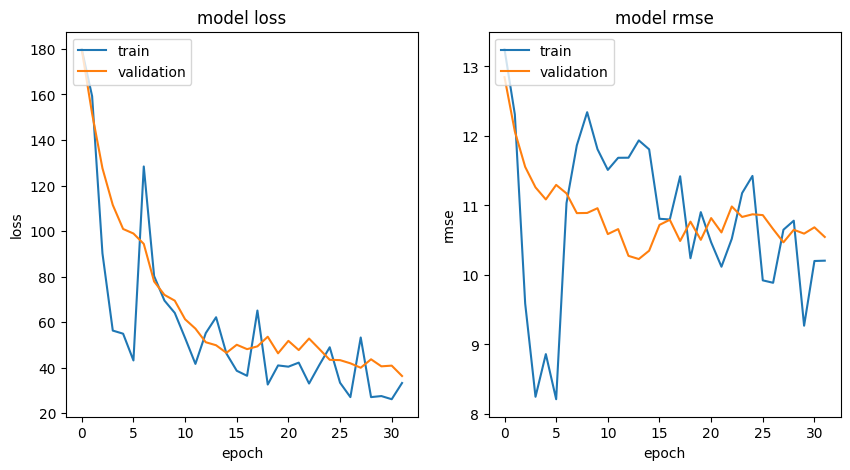

In [17]:
# plot - my code
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

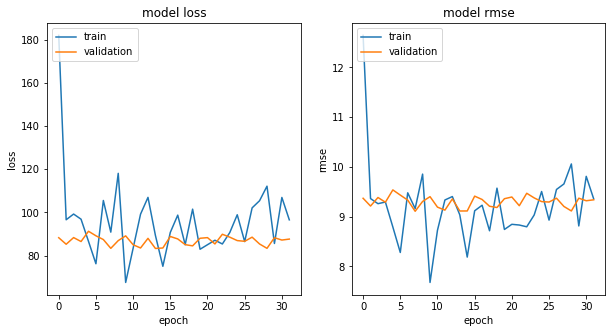

In [28]:
# plot - provided code - left in for comparison of results
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Lab Task 5: Predict with the model locally

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for.

In [51]:
featuresx = tf.constant([[1, 3], [2, 1], [3, 3]])
features_dsx = Dataset.from_tensor_slices(featuresx)
features_dsx
import pandas as pd

x = np.array([tf.convert_to_tensor([-73.982683]),
                tf.convert_to_tensor([40.742104]),
                tf.convert_to_tensor([-73.983766]),
                tf.convert_to_tensor([40.755174]),
                tf.convert_to_tensor([3.0])])
print(x.shape)
print(x.T.shape)

df2 = pd.DataFrame(x.T ,columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count'])

(5, 1)
(1, 5)


In [56]:
tf.convert_to_tensor(-73.982683)

<tf.Tensor: shape=(), dtype=float32, numpy=-73.98268>

In [62]:
# Predicted result in solutions notebook: array([[16.609783]], dtype=float32)

model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),    
}, steps=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[24681.35]], dtype=float32)

Of course, this is not realistic, because we can't expect client code to have a model object in memory. We'll have to export our model to a file, and expect client code to instantiate the model from that exported file.

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.